# Analysing Spotify Songs by Genre

This notebook is intended to analyse correlations between features of Spotify tracks separated by genre in order to find out how they differ.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support,confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression


%matplotlib inline

In [19]:
#tracks = pd.read_csv("spotify_raw.csv", index_col =0)
tracks = pd.read_csv("spotify.csv", index_col =0)
tracks.dropna(inplace = True)

In [20]:
#genres = tracks.track_genre.unique().tolist()
genres = tracks.genre_group.unique().tolist()
print(genres)
len(genres)

['acoustic_folk', 'hiphop_reggae', 'rock_metal', 'ambient', 'happy_kids', 'latin', 'electro', 'pop', 'dance']


9

In [21]:
tracks.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,105999.000000,1.059990e+05,105999.000000,105999.000000,105999.000000,105999.000000,105999.000000,105999.000000,105999.000000,105999.000000,105999.000000,105999.000000,105999.000000,105999.000000
mean,33.203351,2.266732e+05,0.568838,0.646555,5.308890,-8.166294,0.640761,0.084627,0.310594,0.156173,0.215232,0.479914,122.419161,3.907150
std,22.447081,1.063767e+05,0.171516,0.251323,3.558351,4.973730,0.479780,0.106536,0.332433,0.309015,0.192149,0.258785,30.002022,0.426886
min,0.000000,1.745300e+04,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.734130e+05,0.459000,0.478000,2.000000,-9.925000,0.000000,0.036000,0.015200,0.000000,0.098000,0.266000,99.739500,4.000000
50%,34.000000,2.120930e+05,0.581000,0.692000,5.000000,-6.928000,1.000000,0.049100,0.160000,0.000044,0.133000,0.471000,122.133000,4.000000
75%,50.000000,2.597910e+05,0.695000,0.858000,8.000000,-4.936000,1.000000,0.084500,0.592000,0.052000,0.277000,0.689000,140.182000,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [22]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105999 entries, 0 to 111999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          105999 non-null  object 
 1   artists           105999 non-null  object 
 2   album_name        105999 non-null  object 
 3   track_name        105999 non-null  object 
 4   popularity        105999 non-null  int64  
 5   duration_ms       105999 non-null  int64  
 6   explicit          105999 non-null  bool   
 7   danceability      105999 non-null  float64
 8   energy            105999 non-null  float64
 9   key               105999 non-null  int64  
 10  loudness          105999 non-null  float64
 11  mode              105999 non-null  int64  
 12  speechiness       105999 non-null  float64
 13  acousticness      105999 non-null  float64
 14  instrumentalness  105999 non-null  float64
 15  liveness          105999 non-null  float64
 16  valence           10

In [23]:
tracks.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre_group
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic_folk
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic_folk
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic_folk
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic_folk
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic_folk


In [24]:
tracks.drop(['album_name','track_name','track_id','artists', 'popularity', 'explicit', 'time_signature', "duration_ms"], axis=1, inplace = True)

In [29]:
# Function to sample each genre group
def stratified_sample(df, group_col, n_samples, random_state=42):
    return df.groupby(group_col, group_keys=False).apply(lambda x: x.sample(n=min(len(x), n_samples), random_state=random_state))

# Perform stratified sampling
tracks_sample = stratified_sample(tracks, 'genre_group', 7000)  # Sample 7000 tracks per genre

# Check the sampled data
print(tracks_sample['genre_group'].value_counts())


electro          7000
hiphop_reggae    7000
rock_metal       7000
dance            7000
happy_kids       7000
latin            7000
acoustic_folk    7000
pop              7000
ambient          7000
Name: genre_group, dtype: int64


In [34]:
# data = tracks.drop("track_genre", axis = 1)
# target = tracks["track_genre"]
data = tracks_sample.drop("genre_group", axis = 1)
target = tracks_sample["genre_group"]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.1, random_state = 123, stratify=target)

In [36]:
scaler = StandardScaler() 

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

# K-nearest Neighbor 

Best parameters determined through GridSearch: {'metric': 'manhattan', 'n_neighbors': 30}

In [37]:
knn = KNeighborsClassifier(n_neighbors = 30, metric = "manhattan")
knn.fit(X_train_sc, y_train)
y_pred_knn = knn.predict(X_test_sc)
pd.crosstab(y_test, y_pred_knn, rownames=['Real Class'], colnames=['Predicted Class'])

Predicted Class,acoustic_folk,ambient,dance,electro,happy_kids,hiphop_reggae,latin,pop,rock_metal
Real Class,,,,,,,,,
acoustic_folk,356,66,34,18,15,28,60,85,38
ambient,109,402,26,26,24,23,27,44,19
dance,50,7,294,108,20,79,41,49,52
electro,21,27,92,383,16,56,18,36,51
happy_kids,79,90,74,64,154,51,42,76,70
hiphop_reggae,78,36,111,69,17,246,86,34,23
latin,97,23,56,20,25,118,277,57,27
pop,147,29,85,44,19,47,50,179,100
rock_metal,60,8,70,77,20,20,41,59,345


In [ ]:
print(classification_report(y_test, y_pred_knn))

In [38]:
knn.score(X_train_sc, y_train)

0.4569488536155203

In [39]:
knn.score(X_test_sc, y_test)

0.4184126984126984

In [41]:
report = classification_report(y_test, y_pred_knn)
print(classification_report(y_test, y_pred_knn))

               precision    recall  f1-score   support

acoustic_folk       0.36      0.51      0.42       700
      ambient       0.58      0.57      0.58       700
        dance       0.35      0.42      0.38       700
      electro       0.47      0.55      0.51       700
   happy_kids       0.50      0.22      0.30       700
hiphop_reggae       0.37      0.35      0.36       700
        latin       0.43      0.40      0.41       700
          pop       0.29      0.26      0.27       700
   rock_metal       0.48      0.49      0.48       700

     accuracy                           0.42      6300
    macro avg       0.43      0.42      0.41      6300
 weighted avg       0.43      0.42      0.41      6300



F1 Scores vary wildly depending on genre, which suggests that some genres seem to be more easily detected than others.
Best and worst scores are determined in the following steps.

In [42]:
allscores = precision_recall_fscore_support(y_test, y_pred_knn)[2]

scoresbygenre = pd.DataFrame(list(zip(genres, allscores)), columns=["genre", "score"])
scoresbygenre.sort_values(by="score")

,genre,score
7,pop,0.271418
4,happy_kids,0.304950
5,latin,0.359649
2,rock_metal,0.381323
6,electro,0.412817
0,acoustic_folk,0.419564
8,dance,0.484211
3,ambient,0.507621
1,hiphop_reggae,0.579251


<Figure size 20000x20000 with 0 Axes>

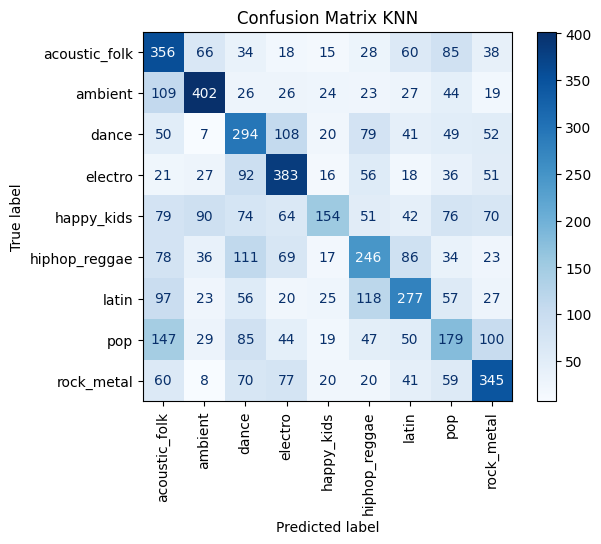

In [90]:
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['acoustic_folk', 'ambient', 'dance', 'electro', 'happy_kids','hiphop_reggae', 'latin', 'pop', 'rock_metal'])
plt.figure(figsize=(200,200))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.title("Confusion Matrix KNN");

# Decision Tree

Best parameters detemined through GridSearch (as calculated below) {'criterion': 'gini', 'splitter': 'best'}

In [44]:

dt_clf = DecisionTreeClassifier(criterion = "gini", max_depth =None, random_state = 123)
dt_clf.fit(X_train_sc, y_train)

DecisionTreeClassifier(random_state=123)

In [45]:
y_pred_dt = dt_clf.predict(X_test_sc)
pd.crosstab(y_test, y_pred_dt, rownames=['Real Class'], colnames=['Predicted Class'])

Predicted Class,acoustic_folk,ambient,dance,electro,happy_kids,hiphop_reggae,latin,pop,rock_metal
Real Class,,,,,,,,,
acoustic_folk,266,71,50,12,54,43,80,81,43
ambient,85,353,24,28,72,32,36,52,18
dance,36,24,217,111,67,67,59,66,53
electro,25,43,108,285,68,60,27,43,41
happy_kids,43,77,56,52,246,42,58,80,46
hiphop_reggae,41,36,78,51,72,241,84,61,36
latin,57,39,42,16,85,127,254,46,34
pop,92,42,77,53,68,51,63,174,80
rock_metal,51,29,79,68,71,35,39,86,242


In [48]:
print(classification_report(y_test, y_pred_dt))

               precision    recall  f1-score   support

acoustic_folk       0.38      0.38      0.38       700
      ambient       0.49      0.50      0.50       700
        dance       0.30      0.31      0.30       700
      electro       0.42      0.41      0.41       700
   happy_kids       0.31      0.35      0.33       700
hiphop_reggae       0.35      0.34      0.34       700
        latin       0.36      0.36      0.36       700
          pop       0.25      0.25      0.25       700
   rock_metal       0.41      0.35      0.37       700

     accuracy                           0.36      6300
    macro avg       0.36      0.36      0.36      6300
 weighted avg       0.36      0.36      0.36      6300



In [ ]:
param_dt = {"criterion": ["gini", "entropy", "log_loss"], "splitter": ["best", "random"]}
grid_dt = GridSearchCV(estimator=dt_clf, param_grid=param_dt)
grid_dt.fit(X_train_sc, y_train)

print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:,['params', 'mean_test_score']])


                                            params  mean_test_score
0        {'criterion': 'gini', 'splitter': 'best'}         0.213851
1      {'criterion': 'gini', 'splitter': 'random'}         0.194991
2     {'criterion': 'entropy', 'splitter': 'best'}         0.210386
3   {'criterion': 'entropy', 'splitter': 'random'}         0.191384
4    {'criterion': 'log_loss', 'splitter': 'best'}         0.210386
5  {'criterion': 'log_loss', 'splitter': 'random'}         0.191384


NameError: name 'grid_knn' is not defined

<Figure size 20000x20000 with 0 Axes>

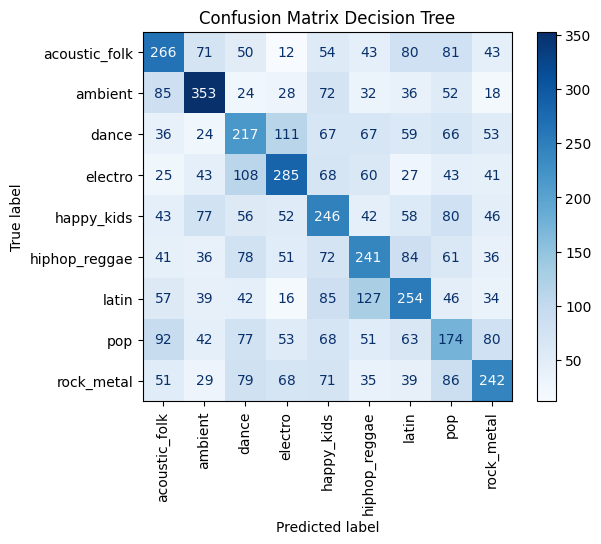

In [91]:
cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['acoustic_folk', 'ambient', 'dance', 'electro', 'happy_kids','hiphop_reggae', 'latin', 'pop', 'rock_metal'])
plt.figure(figsize=(200,200))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.title("Confusion Matrix Decision Tree");

Overall, the decision tree classifier performs worse than the KNN model. 

# Random Forest

Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 1}

In [8]:
rf = RandomForestClassifier(n_jobs=-1, random_state = 321)
param_rf = {"max_depth": [10,20, 30, None],
            "min_samples_leaf": [1,2,4]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_rf, cv= 5, n_jobs=-1, verbose=2, scoring="accuracy")


In [61]:
rf = RandomForestClassifier(max_depth = 20, min_samples_leaf=1, n_estimators=300, n_jobs=-1, random_state = 321)

In [9]:
grid_search.fit(X_train_sc, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\anna_\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
23 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\anna_\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
  File "c:\Users\anna_\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
  File "c:\Users\anna_\AppData\Local\Programs\Python\Python38\lib\site-packages\j

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=321),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [10]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 300}
Best Score:  0.3328882069744326


In [62]:
rf.fit(X_train_sc, y_train)


RandomForestClassifier(max_depth=20, n_estimators=300, n_jobs=-1,
                       random_state=321)

In [63]:
y_pred_rf = rf.predict(X_test_sc)
pd.crosstab(y_test, y_pred_rf, rownames=['Real Class'], colnames=['Predicted Class'])

Predicted Class,acoustic_folk,ambient,dance,electro,happy_kids,hiphop_reggae,latin,pop,rock_metal
Real Class,,,,,,,,,
acoustic_folk,410,56,13,11,21,12,64,80,33
ambient,67,448,14,18,38,29,23,46,17
dance,15,7,315,122,40,55,50,51,45
electro,3,36,90,425,26,44,18,27,31
happy_kids,40,82,69,51,253,23,50,81,51
hiphop_reggae,40,35,76,44,27,307,110,40,21
latin,49,27,40,7,36,126,354,40,21
pop,81,35,76,31,32,30,57,262,96
rock_metal,34,14,43,55,23,25,54,60,392


In [84]:
print(classification_report(y_test, y_pred_rf))

               precision    recall  f1-score   support

acoustic_folk       0.55      0.59      0.57       700
      ambient       0.61      0.64      0.62       700
        dance       0.43      0.45      0.44       700
      electro       0.56      0.61      0.58       700
   happy_kids       0.51      0.36      0.42       700
hiphop_reggae       0.47      0.44      0.45       700
        latin       0.45      0.51      0.48       700
          pop       0.38      0.37      0.38       700
   rock_metal       0.55      0.56      0.56       700

     accuracy                           0.50      6300
    macro avg       0.50      0.50      0.50      6300
 weighted avg       0.50      0.50      0.50      6300



<Figure size 20000x20000 with 0 Axes>

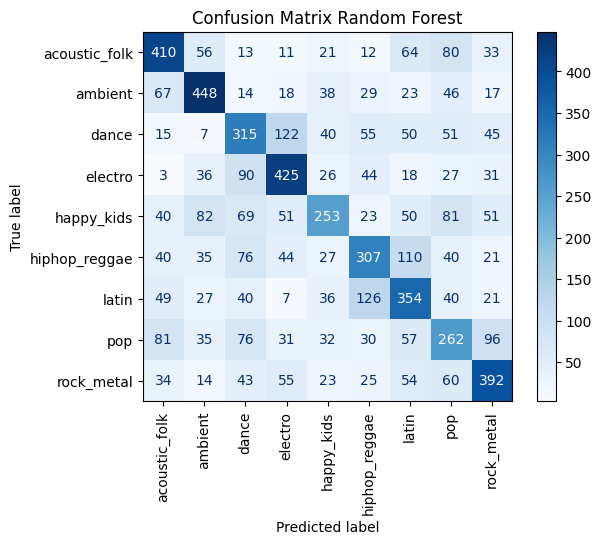

In [92]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['acoustic_folk', 'ambient', 'dance', 'electro', 'happy_kids','hiphop_reggae', 'latin', 'pop', 'rock_metal'])
plt.figure(figsize=(200,200))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.title("Confusion Matrix Random Forest");

The RandomForest Classifier performs better than the KNN classifier. It has to be noted that the genres that have the highest and lowest scores respectively vary from the KNN classifier. We can also see that the f1-score varies less among the classes than with other classifiers.   

In [66]:
allscores = precision_recall_fscore_support(y_test, y_pred_rf)[2]

scoresbygenre = pd.DataFrame(list(zip(genres, allscores)), columns=["genre", "score"])
scoresbygenre.sort_values(by="score")

,genre,score
7,pop,0.377794
4,happy_kids,0.423077
2,rock_metal,0.438719
5,latin,0.454478
6,electro,0.478378
8,dance,0.557214
0,acoustic_folk,0.569840
3,ambient,0.580601
1,hiphop_reggae,0.622222


# Support Vector Machine

Best parameters according to GridSearch: {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}

In [68]:

svm_clf = SVC()
param_svm = {"C": [0.1,1,10],
             "kernel": ["rbf", "linear", "poly"],
             "gamma":[0.001,0.1,0.5]}

grid_search_svm = GridSearchCV(estimator=svm_clf, param_grid=param_svm, cv= 3, n_jobs=-1, verbose=2, scoring="accuracy")


In [69]:
grid_search_svm.fit(X_train_sc, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.1, 0.5],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='accuracy', verbose=2)

In [70]:
print(grid_search_svm.best_params_)

{'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}


In [71]:
svm_clf = SVC(C=1, gamma=0.5, kernel="rbf")
svm_clf.fit(X_train_sc, y_train)

SVC(C=1, gamma=0.5)

In [74]:
y_pred_svm = svm_clf.predict(X_test_sc)
pd.crosstab(y_test, y_pred_svm, rownames=['Real Class'], colnames=['Predicted Class'])

Predicted Class,acoustic_folk,ambient,dance,electro,happy_kids,hiphop_reggae,latin,pop,rock_metal
Real Class,,,,,,,,,
acoustic_folk,349,68,26,16,15,25,55,109,37
ambient,78,427,16,21,37,33,26,47,15
dance,30,7,272,123,44,73,43,52,56
electro,13,28,79,399,27,53,21,33,47
happy_kids,60,84,66,47,222,40,43,73,65
hiphop_reggae,48,40,78,58,20,305,80,44,27
latin,70,23,42,17,35,124,297,60,32
pop,119,28,78,49,25,46,52,189,114
rock_metal,53,10,34,55,27,31,38,56,396


In [75]:
print(classification_report(y_test, y_pred_svm))

               precision    recall  f1-score   support

acoustic_folk       0.43      0.50      0.46       700
      ambient       0.60      0.61      0.60       700
        dance       0.39      0.39      0.39       700
      electro       0.51      0.57      0.54       700
   happy_kids       0.49      0.32      0.39       700
hiphop_reggae       0.42      0.44      0.43       700
        latin       0.45      0.42      0.44       700
          pop       0.29      0.27      0.28       700
   rock_metal       0.50      0.57      0.53       700

     accuracy                           0.45      6300
    macro avg       0.45      0.45      0.45      6300
 weighted avg       0.45      0.45      0.45      6300



<Figure size 20000x20000 with 0 Axes>

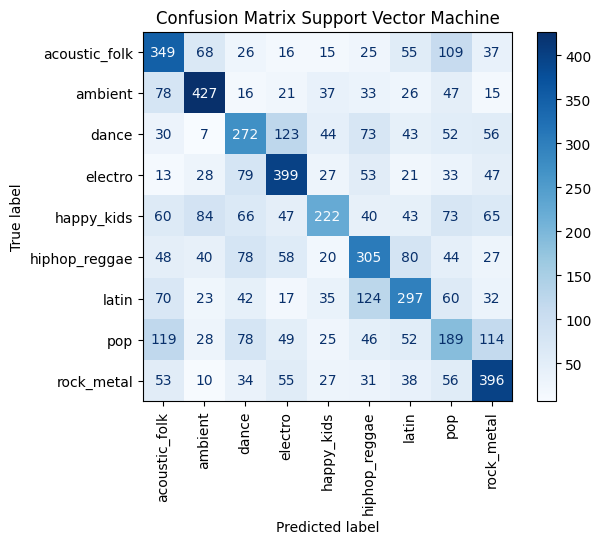

In [93]:
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['acoustic_folk', 'ambient', 'dance', 'electro', 'happy_kids','hiphop_reggae', 'latin', 'pop', 'rock_metal'])
plt.figure(figsize=(200,200))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.title("Confusion Matrix Support Vector Machine");